# Imports and Dependencies

In [3]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Drone_Recog/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [5]:
h, w = 224, 224
epochs = 500
seq = 50
vid_path = 'datasets/Actions'
OP_path = 'datasets/OpenPose'

class_names = os.listdir(vid_path)
num_class = len(class_names)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Apr 28 14:41:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparing Dataset

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
def get_frames(path):
    """
    Function extracts frames of video after it is resize and normalized
    in the form of a list.
    :param path: path of video
    :return: list of frames of every video
    """

    frame_list = []

    # set capture object and count frames
    vid_reader = cv2.VideoCapture(path)
    frame_count = int(vid_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(int(frame_count / seq), 1)

    # extracting frames
    for i in range(seq):
        # skip a couple of frames (don't need everything)
        vid_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        success, frame = vid_reader.read()
        # if no more frames, finish
        if not success:
            break
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, (w, h))
        frame = frame / 255
        frame_list.append(frame)
    vid_reader.release()  # release object

    return frame_list

RGB

In [ ]:
feat = []
lbl = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting rgb from: {class_name}')  # show progress
    files = os.listdir(os.path.join(vid_path, class_name))
    for name in files:
        print(f'    {name}...')
        path = os.path.join(vid_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == seq:
            feat.append(frames)
            lbl.append(idx)

Extracting rgb from: clapping
    S3_clapping_HD.mp4...
    S4_clapping_HD.mp4...
    S5_clapping_HD.mp4...
    S6_clapping_HD.mp4...
    S7_clapping_HD.mp4...
    S8_clapping_HD.mp4...
    S9_clapping_HD.mp4...
    S10_clapping_HD.mp4...
    S1_clapping_HD.mp4...
    S2_clapping_HD.mp4...
Extracting rgb from: kicking
    S1_kicking_toLeft_HD.mp4...
    S3_kicking_toRight_HD.mp4...
    S3_kicking_toLeft_HD.mp4...
    S4_kicking_toRight_HD.mp4...
    S4_kicking_toLeft_HD.mp4...
    S5_kicking_toRight_HD.mp4...
    S5_kicking_toLeft_HD.mp4...
    S6_kicking_toRight_HD.mp4...
    S6_kicking_toLeft_HD.mp4...
    S7_kicking_toLeft_HD.mp4...
    S7_kicking_toRight_HD.mp4...
    S8_kicking_toRight_HD.mp4...
    S8_kicking_toLeft_HD.mp4...
    S9_kicking_toRight_HD.mp4...
    S9_kicking_toLeft_HD.mp4...
    S10_kicking_toRight_HD.mp4...
    S10_kicking_toLeft_HD.mp4...
    S1_kicking_toRight_HD.mp4...
    S2_kicking_toRight_HD.mp4...
    S2_kicking_toLeft_HD.mp4...
Extracting rgb from: stabbin

In [ ]:
# converting to array
feat = np.asarray(feat)
lbl = np.array(lbl)

print(feat.shape)
print(lbl.shape)

(116, 50, 224, 224, 3)
(116,)


In [ ]:
print(lbl)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8
 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [ ]:
# saving to numpy arrays
if not os.path.exists('datasets/image_array'):
    os.makedirs('datasets/image_array')
    print("Created new directory 'image_array' in datasets")
np.save(f'datasets/image_array/{h}x{w}_feat_{seq}', feat)
np.save(f'datasets/image_array/{h}x{w}_lbl_{seq}', lbl)

OpenPose

In [ ]:
OP_feat = []
OP_lbl = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting openpose data from: {class_name}')  # show progress
    files = os.listdir(os.path.join(OP_path, class_name))
    for name in files:
        print(f'    {name}...')
        path = os.path.join(OP_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == seq:
            OP_feat.append(frames)
            OP_lbl.append(idx)

Extracting openpose data from: clapping
    S9_clapping_HD.mp4...
    S2_clapping_HD.mp4...
    S10_clapping_HD.mp4...
    S1_clapping_HD.mp4...
    S6_clapping_HD.mp4...
    S7_clapping_HD.mp4...
    S4_clapping_HD.mp4...
    S3_clapping_HD.mp4...
    S5_clapping_HD.mp4...
    S8_clapping_HD.mp4...
Extracting openpose data from: kicking
    S9_kicking_toLeft_HD.mp4...
    S7_kicking_toLeft_HD.mp4...
    S3_kicking_toRight_HD.mp4...
    S5_kicking_toLeft_HD.mp4...
    S6_kicking_toRight_HD.mp4...
    S10_kicking_toLeft_HD.mp4...
    S6_kicking_toLeft_HD.mp4...
    S8_kicking_toLeft_HD.mp4...
    S8_kicking_toRight_HD.mp4...
    S2_kicking_toLeft_HD.mp4...
    S9_kicking_toRight_HD.mp4...
    S4_kicking_toRight_HD.mp4...
    S2_kicking_toRight_HD.mp4...
    S3_kicking_toLeft_HD.mp4...
    S4_kicking_toLeft_HD.mp4...
    S1_kicking_toRight_HD.mp4...
    S5_kicking_toRight_HD.mp4...
    S7_kicking_toRight_HD.mp4...
    S10_kicking_toRight_HD.mp4...
    S1_kicking_toLeft_HD.mp4...
Extracti

In [ ]:
# converting to array
OP_feat = np.asarray(OP_feat)
OP_lbl = np.array(OP_lbl)

print(OP_feat.shape)
print(OP_lbl.shape)

(116, 50, 224, 224, 3)
(116,)


In [ ]:
# saving to numpy arrays
if not os.path.exists('datasets/image_array'):
    os.makedirs('datasets/image_array')
    print("Created new directory 'image_array' in datasets")
np.save(f'datasets/image_array/{h}x{w}_OPfeat_{seq}', OP_feat)
np.save(f'datasets/image_array/{h}x{w}_OPlbl_{seq}', OP_lbl)

# Data Augmentation

In [ ]:
import os
import glob
import keras

from keras_video import VideoFrameGenerator

h, w = 224, 224
epochs = 500
seq = 50
vid_path = 'datasets/Actions'
OP_path = 'datasets/OpenPose'

class_names = os.listdir(vid_path)
num_class = len(class_names)

In [ ]:
glob_pattern = 'datasets/Actions/{classname}/*.mp4'
print(glob_pattern)

datasets/Actions/{classname}/*.mp4


In [ ]:
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range = .1,
    rotation_range = 4,
    width_shift_range = .2,
    height_shift_range = .2
)

In [ ]:
train = VideoFrameGenerator(
    classes= class_names,
    glob_pattern = glob_pattern,
    nb_frames = seq,
    split = .35,
    shuffle = True,
    batch_size = 4,
    target_shape = (224, 224),
    nb_channel = 3,
    transformation = data_aug
)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class clapping, validation count: 3, train count: 7
class hitting, validation count: 6, train count: 13
class kicking, validation count: 7, train count: 13
class stabbing, validation count: 7, train count: 13
class walking_f_b, validation count: 7, train count: 13
class walking_side, validation count: 7, train count: 13
class waving_hands, validation count: 3, train count: 7
Total data: 7 classes for 79 files for train


In [ ]:
valid = train.get_validation_generator()

Total data: 7 classes for 40 files for validation


In [ ]:
da_x = []
da_y = []
for x, y in valid:
  da_x.append(x)
  da_y.append(y)

Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video datasets/Actions/walking_side/S3_walking_toRight_sideView_HD.mp4, 48 total, 48 extracted
Frame count is not OK for video 

# Model

## *3D CNN*

Simplified Model

In [ ]:
# 3D CNN
def build_3DConv():
    In = Input(shape=(seq, h, w, 3), name='3DCNN_Input')
    x = Conv3D(32, (3, 3, 3), strides = (1, 2, 2), padding='same', activation='relu', name='conv3d_1')(In)
    x = MaxPooling3D(pool_size=(1, 4, 4), strides = (1, 4, 4), name='pool_1')(x)

    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_2')(x)

    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_3')(x)

    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_4')(x)

    x = Dropout(0.65, name = 'dropout')(x)
    
    return Model(In, x, name = '3DConv')

In [ ]:
# inputs
LRCN_in = Input(shape=(seq, h, w, 3), name = '3DCNN_Input')

# build 3d-cnn
Conv3d = build_3DConv()

# passing input through 3d CNN
cnn_3d = Conv3d(LRCN_in)

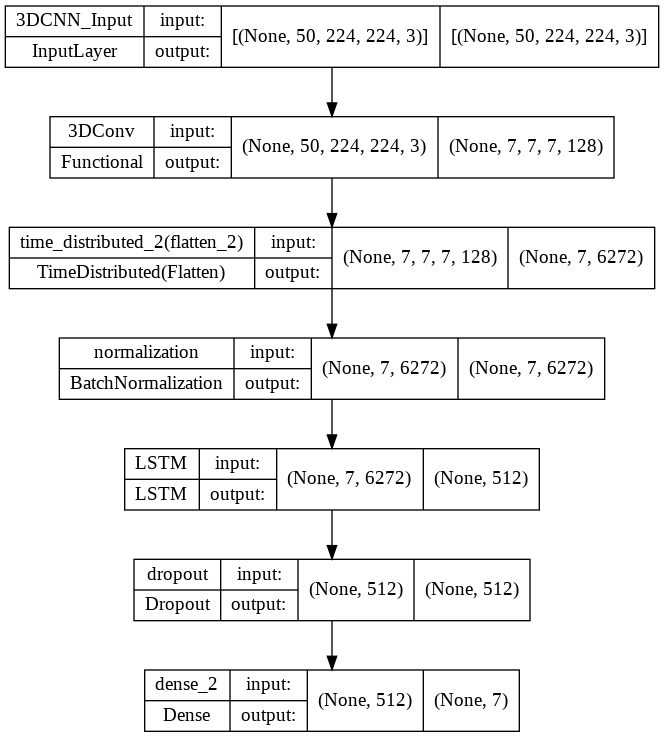

In [ ]:
# LSTM network
x = TimeDistributed(Flatten())(cnn_3d)
x = BatchNormalization(name = 'normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
LRCN_model = Model(LRCN_in, LRCN_out, name = 'LRCN_Model')
plot_model(LRCN_model, show_shapes = True)

## *Time-Distributed CNN*

In [ ]:
# Time-Distributed(td)-CNN
def build_td_cnn():
    In = Input(shape=(seq, h, w, 3), name='CNN_Input')
    x = TimeDistributed(Conv2D(32, (3, 3), strides = 2, padding='same', activation='relu'), name='conv_1')(In)
    x = TimeDistributed(MaxPooling2D(4, strides = 4), name = 'pool_1')(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'), name='conv_2')(x)
    x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_2')(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3b')(x)
    x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_3')(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4b')(x)
    x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_4')(x)

    x = TimeDistributed(Dropout(0.6), name = 'dropout')(x)
    
    return Model(In, x, name = 'td_CNN')

In [ ]:
# inputs
LRCN_in = Input(shape=(seq, h, w, 3), name = 'CNN_Input')

# build td-cnn
cnn = build_td_cnn()

# passing input through CNN
CNN = cnn(LRCN_in)

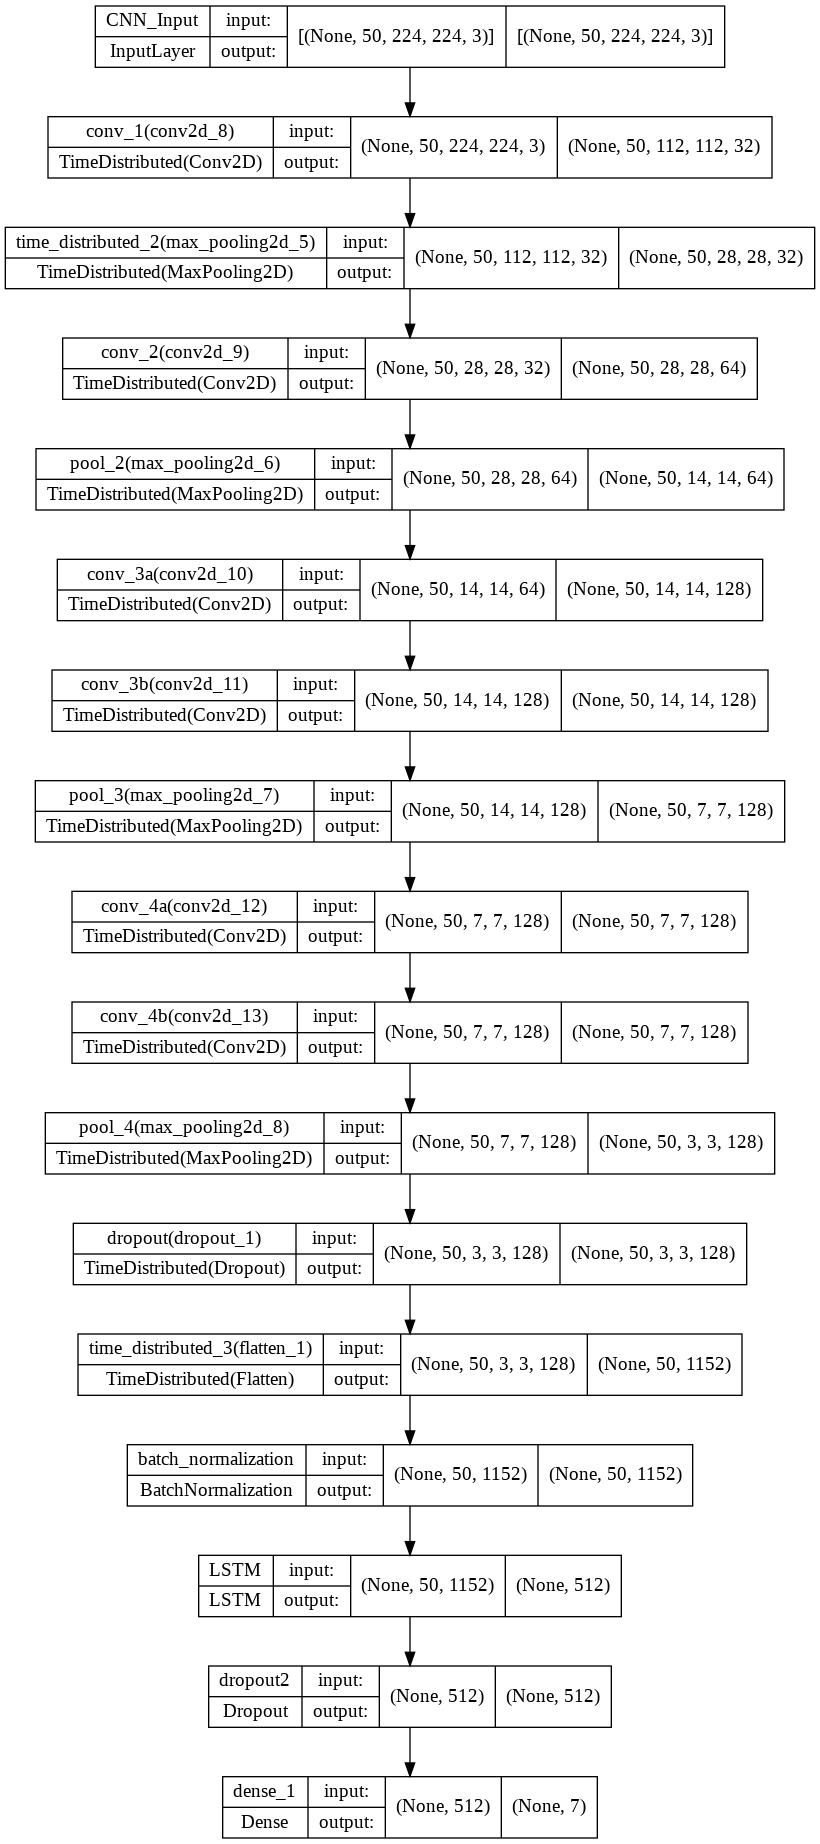

In [11]:
# LSTM network
In = Input(shape=(seq, h, w, 3), name='CNN_Input')
x = TimeDistributed(Conv2D(32, (3, 3), strides = 2, padding='same', activation='relu'), name='conv_1')(In)
x = (MaxPooling2D(4)(x)

x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'), name='conv_2')(x)
x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_2')(x)

x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3a')(x)
x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_3b')(x)
x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_3')(x)

x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4a')(x)
x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name='conv_4b')(x)
x = TimeDistributed(MaxPooling2D(2, strides = 2), name = 'pool_4')(x)

x = TimeDistributed(Dropout(0.6), name = 'dropout')(x)
x = TimeDistributed(Flatten())(x)
x = BatchNormalization(name = 'batch_normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout2')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
LRCN_model = Model(In, LRCN_out, name = 'LRCN_Model')
plot_model(LRCN_model, show_shapes = True)

# Training

## *Plotting Function*

In [ ]:
def plot_graph(training_history, metric1, metric2, plot_name):
    """
    Function to plot and show graph of accuracy and loss
    :param training_history: record of training and validation (acc/loss)
    :param metric1: first metric
    :param metric2: second metric
    :param plot_name: name of plot
    """

    # Get metric values using metric names as identifiers.
    metric_1 = training_history.history[metric1]
    metric_2 = training_history.history[metric2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_1))

    # Plotting
    plt.plot(epochs, metric_1, 'blue', label=metric1)
    plt.plot(epochs, metric_2, 'red', label=metric2)

    # Add title
    plt.title(str(plot_name))

    # Legends
    plt.legend()
    plt.show()

## *Train Data*

In [ ]:
# Get Dataset: rgb
feat = np.load(f'datasets/image_array/{h}x{w}_feat_{seq}.npy')
lbl = np.load(f'datasets/image_array/{h}x{w}_lbl_{seq}.npy')

print(feat.shape)
print(lbl.shape)

(116, 50, 224, 224, 3)
(116,)


In [ ]:
# Get Dataset: openpose
OP_feat = np.load(f'datasets/image_array/{h}x{w}_OPfeat_{seq}.npy')
OP_lbl = np.load(f'datasets/image_array/{h}x{w}_OPlbl_{seq}.npy')

#OP_lbl = to_categorical(OP_lbl, num_classes=num_class)

print(OP_feat.shape)
print(OP_lbl.shape)

(116, 50, 224, 224, 3)
(116,)


In [ ]:
# compile model
LRCN_model.compile(loss = 'sparse_categorical_crossentropy', # measures model accuracy
              optimizer = optimizers.Adam(learning_rate = 0.000005),
              metrics = ['accuracy'])

In [ ]:
# split datasets
feat, X_test, lbl, Y_test = train_test_split(
    feat, lbl, test_size=0.15, shuffle=True, random_state = 25)
feat, X_val, lbl, Y_val = train_test_split(
    feat, lbl, test_size=0.3, shuffle=True, random_state = 124)

print(lbl)
print(Y_val)
print(Y_test)

[2 2 2 3 0 3 3 1 5 1 2 3 2 4 6 0 6 1 5 0 3 4 2 3 1 1 1 3 4 2 0 4 4 3 6 4 1
 0 5 1 3 2 5 0 2 1 4 3 2 1 3 4 2 1 1 5 6 3 0 3 4 2 6 2 6 6 1 6]
[6 6 3 0 6 5 4 2 6 1 1 6 3 4 3 1 2 2 5 1 4 4 6 3 2 6 4 2 3 5]
[1 4 5 6 5 4 0 2 1 6 2 3 3 1 6 4 0 6]


In [ ]:
# create instance of early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience=15,
                                    mode='min', restore_best_weights=True)

In [ ]:
# Run Training
LRCN_history = LRCN_model.fit(feat, lbl,
                              validation_data=(X_val, Y_val),
                              batch_size = 4,
                              epochs=epochs,
                              callbacks=[early_stop_callback])

Epoch 1/500
17/17 [==============================] - 16s 219ms/step - loss: 2.0195 - accuracy: 0.1324 - val_loss: 1.9453 - val_accuracy: 0.1000
Epoch 2/500
17/17 [==============================] - 1s 88ms/step - loss: 1.9852 - accuracy: 0.0882 - val_loss: 1.9447 - val_accuracy: 0.1000
Epoch 3/500
17/17 [==============================] - 1s 86ms/step - loss: 1.9632 - accuracy: 0.1176 - val_loss: 1.9442 - val_accuracy: 0.1000
Epoch 4/500
17/17 [==============================] - 1s 85ms/step - loss: 1.9566 - accuracy: 0.1176 - val_loss: 1.9435 - val_accuracy: 0.0667
Epoch 5/500
17/17 [==============================] - 1s 86ms/step - loss: 1.8985 - accuracy: 0.1765 - val_loss: 1.9430 - val_accuracy: 0.1000
Epoch 6/500
17/17 [==============================] - 1s 84ms/step - loss: 1.8994 - accuracy: 0.2353 - val_loss: 1.9425 - val_accuracy: 0.1333
Epoch 7/500
17/17 [==============================] - 1s 85ms/step - loss: 1.9041 - accuracy: 0.2353 - val_loss: 1.9417 - val_accuracy: 0.2333
Epoc

In [ ]:
# Evaluate Accuracy
test_loss, test_acc = LRCN_model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

1/1 - 1s - loss: 1.6989 - accuracy: 0.3333 - 612ms/epoch - 612ms/step
Test Accuracy: 0.3333333432674408


In [ ]:
# Debug
LRCN_model.summary()

Model: "LRCN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_Input (InputLayer)      [(None, 50, 224, 224, 3)  0         
                             ]                                   
                                                                 
 td_CNN (Functional)         (None, 50, 3, 3, 128)     536000    
                                                                 
 time_distributed (TimeDistr  (None, 50, 1152)         0         
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 50, 1152)         4608      
 ormalization)                                                   
                                                                 
 LSTM (LSTM)                 (None, 512)               3409920   
                                                        

INFO:tensorflow:Assets written to: results/tdLRCN_model__Loss_1.698927402496338__Acc_0.3333333432674408/assets


INFO:tensorflow:Assets written to: results/tdLRCN_model__Loss_1.698927402496338__Acc_0.3333333432674408/assets


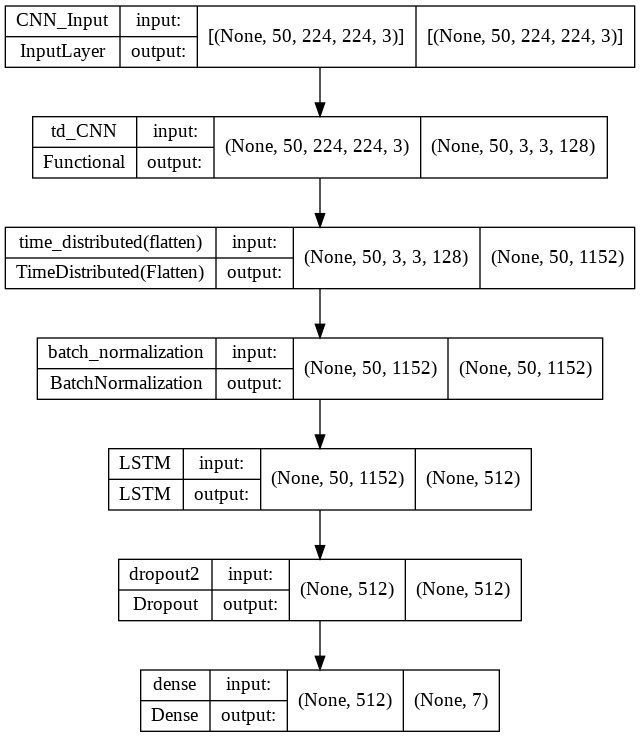

In [ ]:
# saving model
file_name = f'results/tdLRCN_model__Loss_{test_loss}__Acc_{test_acc}'
LRCN_model.save(file_name)
# plot model
plot_model(LRCN_model, to_file=f'{file_name}/Simplified Model.png', 
           show_shapes = True)

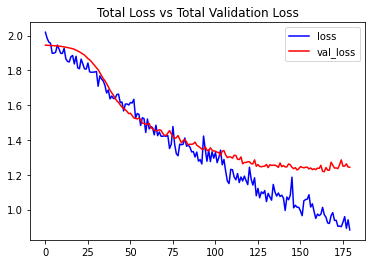

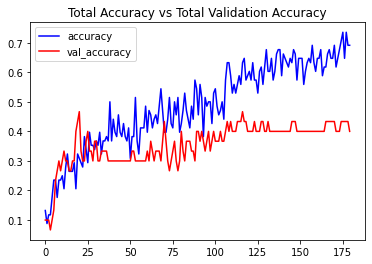

In [ ]:
# plotting loss and accuracy
plot_graph(LRCN_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_graph(LRCN_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Testing and Predictions

## *load data*

In [ ]:
# model directory
!ls results

3LRCN_model__Loss_1.6577669382095337__Acc_0.25
3LRCN_model__Loss_1.682599425315857__Acc_0.3333333432674408
3LRCN_model__Loss_4.3943634033203125__Acc_0.4166666567325592
P_3LRCN_model__Loss_0.7726011276245117__Acc_0.5833333134651184
P_3LRCN_model__Loss_1.0011645555496216__Acc_0.5
P_3LRCN_model__Loss_1.262719988822937__Acc_0.4166666567325592
P_3LRCN_model__Loss_2.1561691761016846__Acc_0.5
P_3LRCN_model__Loss_4.736997604370117__Acc_0.4583333432674408
P_3LRCN_model__Loss_4.838903427124023__Acc_0.5
P_tdLRCN_model__Loss_0.44021937251091003__Acc_0.8333333134651184
P_tdLRCN_model__Loss_1.2910995483398438__Acc_0.4166666567325592
P_tdLRCN_model__Loss_1.4495985507965088__Acc_0.4444444477558136
P_tdLRCN_model__Loss_1.5918797254562378__Acc_0.3333333432674408
P_tdLRCN_model__Loss_1.59621262550354__Acc_0.2777777910232544
tdLRCN_model__Loss_1.698927402496338__Acc_0.3333333432674408
tdLRCN_model__Loss_1.7033807039260864__Acc_0.3333333432674408
tdLRCN_model__Loss_1.7525795698165894__Acc_0.277777791023254

In [ ]:
# load model8
LRCN_model = load_model('results/P_tdLRCN_model__Loss_0.44021937251091003__Acc_0.8333333134651184')

get data

In [ ]:
# normal arrays
feat = np.load(f'datasets/image_array/{h}x{w}_feat_{seq}.npy')
lbl = np.load(f'datasets/image_array/{h}x{w}_lbl_{seq}.npy')
print(feat.shape)

(116, 50, 224, 224, 3)


In [ ]:
# OP arrays
OP_feat = np.load(f'datasets/image_array/{h}x{w}_OPfeat_{seq}.npy')
OP_lbl = np.load(f'datasets/image_array/{h}x{w}_OPlbl_{seq}.npy')
print(OP_feat.shape)


(116, 50, 224, 224, 3)


## *Prediction and plots*

In [ ]:
# Prediction: initializing lists for plot
true_lbl = []
prediction, OP_prediction = [], []
predicted_idx, OP_predicted_idx = [], []
predicted_class, OP_predicted_class = [], []
confidence, OP_confidence = [], []

for i in range(len(OP_feat)):
    # Get sequence of images 1-by-1
    OP_X = np.expand_dims(OP_feat[i], 0)
    X = np.expand_dims(feat[i], 0)

    # predict video using model
    OP_prediction.append(LRCN_model.predict(OP_X))
    prediction.append(LRCN_model.predict(X))

    # save prediction idx labels and true labels
    true_lbl.append(OP_lbl[i])
    predicted_idx.append(np.argmax(prediction[i]))
    OP_predicted_idx.append(np.argmax(OP_prediction[i]))

    # save predicted class names
    predicted_class.append(class_names[np.argmax(prediction[i])])
    OP_predicted_class.append(class_names[np.argmax(OP_prediction[i])])

    # confidence for each video in its class
    confidence.append(round(100*np.max(prediction[i]), 2))
    OP_confidence.append(round(100*np.max(OP_prediction[i]), 2))

In [ ]:
print(f'Confidence: {confidence}\n\n')
print(f'OP_Confidence: {OP_confidence}\n\n')

Confidence: [71.16, 49.83, 79.41, 35.69, 86.74, 85.65, 92.79, 84.7, 20.1, 78.59, 78.38, 67.81, 83.18, 91.79, 79.76, 64.98, 47.01, 78.99, 48.31, 76.4, 88.06, 91.3, 86.04, 91.25, 88.04, 89.86, 90.91, 61.76, 85.4, 49.23, 55.78, 53.76, 72.41, 85.26, 91.15, 83.76, 74.76, 63.68, 43.01, 34.66, 81.68, 72.73, 84.36, 89.71, 85.96, 92.76, 84.77, 85.91, 74.3, 87.78, 88.3, 95.85, 97.06, 98.59, 99.04, 99.13, 98.8, 99.27, 99.57, 99.57, 99.43, 99.63, 99.45, 99.57, 99.4, 99.48, 99.31, 99.5, 99.42, 99.29, 97.94, 97.64, 96.61, 95.49, 97.79, 93.77, 96.6, 95.87, 93.64, 95.62, 94.93, 95.28, 97.0, 96.47, 97.31, 94.76, 96.99, 20.0, 70.2, 62.57, 62.24, 46.84, 90.47, 83.83, 92.1, 86.2, 94.27, 70.15, 32.67, 66.82, 77.57, 89.37, 88.07, 83.31, 62.37, 43.71, 83.65, 63.23, 85.78, 67.72, 90.19, 91.24, 86.93, 34.01, 90.75, 92.5]


OP_Confidence: [47.26, 26.92, 44.42, 36.04, 37.45, 42.18, 29.62, 43.12, 38.62, 38.36, 64.98, 80.46, 46.56, 32.72, 48.42, 52.1, 31.14, 87.44, 35.31, 91.45, 42.77, 71.3, 67.96, 30.77, 59.03, 3

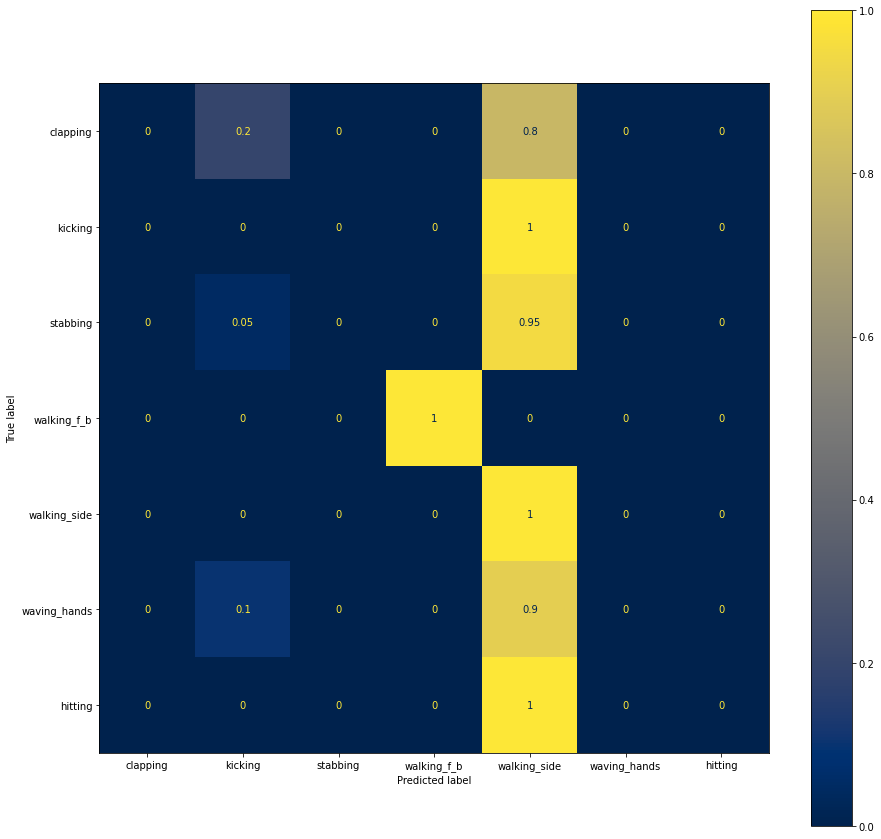

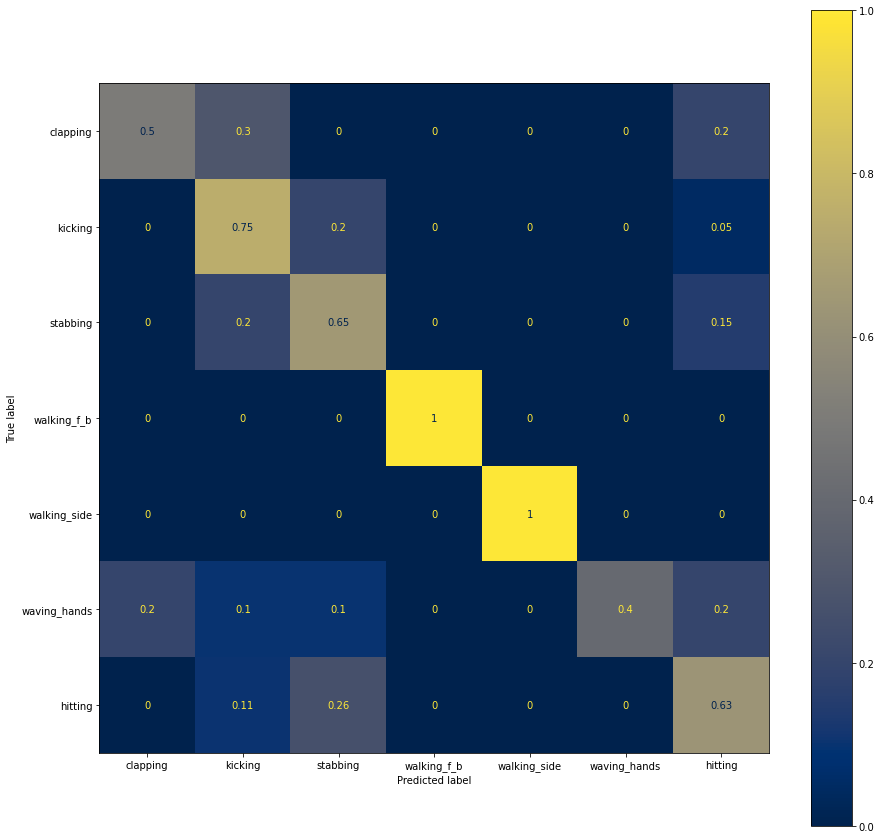

In [ ]:
# Plot Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(15, 15))
fig2, ax2 = plt.subplots(figsize=(15, 15))

pred = ConfusionMatrixDisplay.from_predictions(
    true_lbl,
    predicted_idx,
    display_labels = class_names,
    normalize = 'true',
    include_values = True,
    cmap = plt.cm.cividis,
    colorbar = True,
    ax = ax1
)

OP_pred = ConfusionMatrixDisplay.from_predictions(
    true_lbl,
    OP_predicted_idx,
    display_labels = class_names,
    normalize = 'true',
    include_values = True,
    cmap = plt.cm.cividis,
    colorbar = True,
    ax = ax2
)
plt.show()

In [ ]:
import pandas as pd

# Retrieve Accuracy, Precision, and Recall
report1 = classification_report(true_lbl, 
                            predicted_idx, 
                            target_names = class_names, 
                            digits = 4,
                            zero_division = 0,
                            output_dict=True)

report2 = classification_report(true_lbl, 
                            OP_predicted_idx, 
                            target_names = class_names, 
                            digits = 4,
                            zero_division = 0,
                            output_dict=True)

df1 = pd.DataFrame(report1).transpose()
df2 = pd.DataFrame(report2).transpose()

df1.to_csv('res.csv')
df2.to_csv('OPres.csv')